--- 217.73802280426025  ---


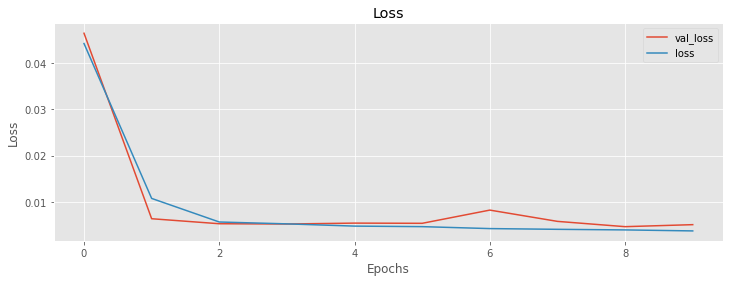

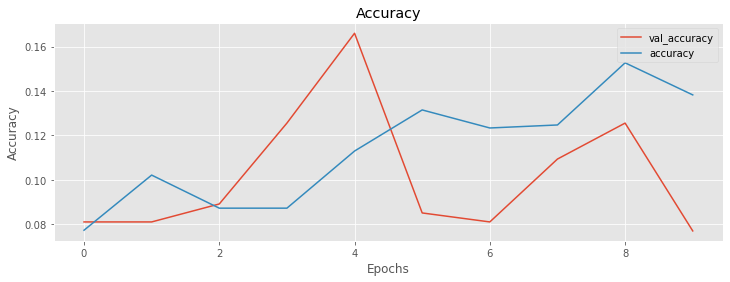

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import time
plt.style.use("ggplot")
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import joblib

start_time = time.time()
df = pd.read_csv('../../../Crypto_Data/Data/bitcoin_new.csv', sep=',')
df = df.set_index("Date")[['Price']].tail(2500)
df = df.set_index(pd.to_datetime(df.index))

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)


def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12, 4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


def split_sequence(seq, n_steps_in, n_steps_out):
    x, y = [], []
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        if out_end > len(seq):
            break

        seq_x, seq_y = seq[i:end], seq[end:out_end]
        x.append(seq_x)
        y.append(seq_y)

    return np.array(x), np.array(y)


def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    for x in range(1, n_layers + 1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass


# Data prep
n_per_in = 30
n_per_out = 10
n_features = 1
x, y = split_sequence(list(df.Price), n_per_in, n_per_out)
x = x.reshape((x.shape[0], x.shape[1], n_features))

# Model
model = Sequential()
activ = "softsign"
# activ = "tanh"
# activ = "relu"
model.add(LSTM(30, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))
layer_maker(n_layers=6, n_nodes=10, activation=activ)
model.add(LSTM(10, activation=activ))
model.add(Dense(n_per_out))
# model.summary()

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
res = model.fit(x, y, epochs=10, batch_size=32, validation_split=0.1, verbose=0)
yhat = model.predict(x[-2].reshape(1, n_per_in, n_features)).tolist()[0]
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1, 1)).tolist()
yhat = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-n_per_out], periods=len(yhat), freq="D"), columns=df.columns)
#joblib.dump(model, './Models/rnn_9.sav')
#joblib.dump(yhat, './Models/yhat_9.sav')
actual = scaler.inverse_transform(y[-1].reshape(-1, 1))
#joblib.dump(actual, './Models/actual_9.sav')
yhat_fut = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]
yhat_fut = scaler.inverse_transform(np.array(yhat_fut).reshape(-1,1)).tolist()
preds = pd.DataFrame(yhat_fut, index=pd.date_range(start=df.index[-1], periods=len(yhat_fut), freq="D"), columns=df.columns)
#joblib.dump(preds, './Models/preds_9.sav')
pers = 30
actual2 = pd.DataFrame(scaler.inverse_transform(df[["Price"]].tail(pers)), index=df.Price.tail(pers).index, columns=df.columns).append(preds.head(1))
#joblib.dump(actual2, './Models/actual2_8.sav')

print("--- %s  ---" % (time.time() - start_time))
visualize_training_results(res)